# How to model reflectivity data using python

## Getting Started

We like to use [uv](https://docs.astral.sh/uv/pip/compatibility/) for manaiging python.
To get started, ensure you have a virtual environment set up.

```bash
# using pip
python -p venv .venv
# using uv
uv venv
# activate the environment
.venv/Scripts/activate.exe
```

Once this is set up install pyref into your environment. We will also install `pint` a
package for dealing with units

```bash
#using pip
pip install pyref[jupyter], pint
# using uv
uv pip install pyref[jupyter], pint
```

Now that you are set up this should build with all the correct dependenies

## Simulating some Scattering


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import pyref.fitting as fit
from pint import UnitRegistry
import pint

# pyref.fitting is the module responsible for modeling and fitting the data.
# It contains the model definitions and the fitting functions.

# pint is used for unit handling, which is useful for ensuring that the data
# and model parameters are in the correct units.
ureg = UnitRegistry()
# So you can use units like this:
energy = 8.04 * ureg.keV
energy

<Quantity(8.04, 'kiloelectron_volt')>

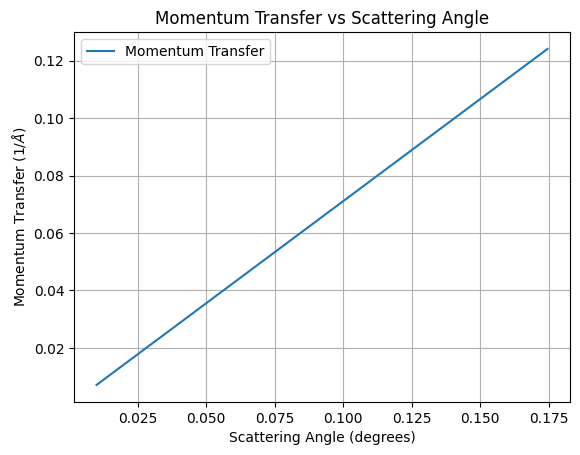

In [ ]:
# We need to use momentum transfer in the model.... so let's do that now.
def momentum_transfer(energy: pint.Quantity, theta: pint.Quantity) -> pint.Quantity:
    """
    Calculate the momentum transfer for a given energy and scattering angle.

    Parameters
    ----------
    energy : pint.Quantity
        The energy of the incident photon.
    theta : pint.Quantity
        The scattering angle.

    Returns
    -------
    pint.Quantity
        The calculated momentum transfer.
    """
    hc = (
        1239.84193 * ureg.eV * ureg.angstrom
    )  # Planck's constant times speed of light in eV angstroms
    lambda_ = hc / energy.to(ureg.eV)  # Wavelength in angstroms
    q = (4 * np.pi / lambda_) * np.sin(
        theta / 2
    )  # Momentum transfer in inverse angstroms
    return q.to(ureg.angstrom**-1)  # Return in inverse angstroms


MAX_THETA = 10 * ureg.deg  # Maximum scattering angle for the plot, this is a guess

theta = (
    np.linspace(0.01, MAX_THETA, 1000) * ureg.deg
)  # Scattering angles from 0 to 10 degrees
q = momentum_transfer(energy, theta)  # Calculate momentum transfer
# Plotting the momentum transfer
fig, ax = plt.subplots()
ax.plot(theta.to(ureg.deg), q.to(ureg.angstrom**-1), label="Momentum Transfer")
ax.set_xlabel("Scattering Angle (degrees)")
ax.set_ylabel(r"Momentum Transfer $(1/\AA)$")
ax.set_title("Momentum Transfer vs Scattering Angle")
ax.legend()
plt.grid()
plt.show()

### Using Pyref


In [ ]:
# pyref constructs a model based on the optical constants defined in each layer of a
# multilayer structure. To do this, we need to define the layers and their properties.

# Material SLDs (Scattering Length Densities) are used to define the optical properties
# a layer based on the composition and density of the material, using the constants you
# can find in a database like the NIST X-ray and neutron scattering database.
vacuum_generator = fit.MaterialSLD(
    formula="",  # No formula for vacuum
    density=0 * ureg.g / ureg.cm**3,  # Vacuum has no density
    energy=energy.to(ureg.eV).magnitude,  # Energy in eV
    name="Vacuum",  # Name of the material
)
# We can now use this vacuum object as a generatror to build vacuum layers. This is
# done by calling the generate method with the desired thickness and roughness.
print(vacuum_generator(0, 0))

________________________________________________________________________________
Parameters:    'Vacuum'    
________________________________________________________________________________
Parameters:  'Vacuum_slab' 
<Parameter:'Vacuum_thick' , value=0          , bounds=[0.0, 0.0]>
<Parameter:'Vacuum_rough' , value=0          , bounds=[0.0, 0.0]>
<Parameter: 'Vacuum_rho'  , value=0          , bounds=[0.0, 0.0]>


Now let's build all the other slabs. We will need four total slabs
for our multilayer structure:

## Layer Structure Diagram

<div style="width: 20%; height: 350px; position: relative; border: 2px solid #333; display: flex; flex-direction: column; align-items: left; justify-content: left; border-radius: 10px; margin: 0 auto; border-color: transparent;">

  <!-- Container for centered slabs -->
  <div style="position: relative; width: 300px; height: 320px;">
  
  <!-- Vacuum Layer -->
  <div style="position: absolute; top: 20px; left: 50px; width: 200px; height: 60px; background: linear-gradient(135deg, #cce7ff, #e6f3ff); border: 2px solid #007bff; border-radius: 8px; border-top: 2px solid transparent; display: flex; align-items: center; justify-content: center; font-weight: bold; color: #0056b3; box-shadow: 0 3px 10px rgba(0,123,255,0.2); font-size: 14px;">
  Vacuum
  </div>
  
  <!-- Bulk Layer -->
  <div style="position: absolute; top: 80px; left: 50px; width: 200px; height: 150px; background: linear-gradient(135deg, #ffe4cc, #fff2e6); border: 2px solid #fd7e14; border-radius: 8px; display: flex; align-items: center; justify-content: center; font-weight: bold; color: #c65d00; box-shadow: 0 3px 10px rgba(253,126,20,0.2); font-size: 14px;">
  Bulk Material
  </div>
  
  <!-- SiO2 Layer -->
  <div style="position: absolute; top: 230px; left: 50px; width: 200px; height: 20px; background: linear-gradient(135deg, #d1f2d8, #e8f5e8); border: 2px solid #28a745; border-radius: 8px; display: flex; align-items: center; justify-content: center; font-weight: bold; color: #1e7e34; box-shadow: 0 3px 10px rgba(40,167,69,0.2); font-size: 14px;">
  SiO₂
  </div>
  
  <!-- Silicon Substrate -->
  <div style="position: absolute; top: 250px; left: 50px; width: 200px; height: 60px; background: linear-gradient(135deg, #e2e6ea, #f1f3f4); border: 2px solid #6c757d; border-radius: 8px; border-bottom: 2px solid transparent; display: flex; align-items: center; justify-content: center; font-weight: bold; color: #495057; box-shadow: 0 3px 10px rgba(108,117,125,0.2); font-size: 14px;">
  Silicon Substrate
  </div>
  
  <!-- Title -->
  <div style="position: absolute; top: 1px; font-size: 16px; align-items: center; justify-content: center font-weight: bold; color: #333; background: rgba(255,255,255,0.9); padding: 5px 15px; border-radius: 20px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);">
  Multilayer Structure
  </div>
</div>
</div>

This four-layer structure represents a typical sample for X-ray or neutron reflectometry measurements, where each interface contributes to the overall reflectivity profile.


In [ ]:
# The vacuum layer has transparent boundary conditions above the slab, so we set the
# thickness to 0 to signal that this is a boundary slab that extends infinitely.
vacuum = vacuum_generator(
    thick=0,  # For the vacuum layer, we can set thickness to 0
    rough=0,  # Roughness in Angstroms
)

ZNPC = "C32H16N8Zn1"  # Stoichiometry fir Zinc (III) phthalocyanine
bulk_generator = fit.MaterialSLD(
    formula=ZNPC,
    density=(1.6 * ureg.g / ureg.cm**3).magnitude,  # Density of Zinc phthalocyanine
    energy=energy.to(ureg.eV).magnitude,  # Energy in eV
    name="Zinc Phthalocyanine",
)
ELIPS_THICKNESS = 15 * ureg.nm  # Thickness from ellipsometry

bulk = bulk_generator(
    thick=ELIPS_THICKNESS.to(ureg.angstrom).magnitude,  # Convert thickness to Angstroms
    rough=10,  # Roughness in Angstroms this is a good guess
)

oxide_generator = fit.MaterialSLD(
    formula="SiO2",  # Silicon dioxide
    density=(2.2 * ureg.g / ureg.cm**3).magnitude,  # Density of SiO2
    energy=energy.to(ureg.eV).magnitude,  # Energy in eV
    name="Silicon Dioxide",
)
oxide = oxide_generator(
    thick=5,  # Thickness in Angstroms
    rough=1,  # Roughness in Angstroms
)

substrate_generator = fit.MaterialSLD(
    formula="Si",  # Silicon
    density=(2.33 * ureg.g / ureg.cm**3).magnitude,  # Density of Silicon
    energy=energy.to(ureg.eV).magnitude,  # Energy in eV
    name="Silicon Substrate",
)
# The substrate layer has transparent boundary conditions below the slab, so we set the
# thickness to 0 to signal that this is a boundary slab that extends infinitely.
substrate = substrate_generator(
    thick=0,  # For the vacuum and substrate layers, we can set thickness to 0
    rough=1.5,  # This tends to be a good guess for silicon substrates
)

# Now we can create a multilayer structure using these generators, and the elipsometry
# results for thickness and roughness. To build the slab, we use the logical OR "|"
# operator to combine the layers.
slab = vacuum | bulk | oxide | substrate
print(slab)

________________________________________________________________________________
Structure:                
reverse structure: False
________________________________________________________________________________
Parameters:    'Vacuum'    
________________________________________________________________________________
Parameters:  'Vacuum_slab' 
<Parameter:'Vacuum_thick' , value=0          , bounds=[0.0, 0.0]>
<Parameter:'Vacuum_rough' , value=0          , bounds=[0.0, 0.0]>
<Parameter: 'Vacuum_rho'  , value=0          , bounds=[0.0, 0.0]>
________________________________________________________________________________
Parameters: 'Zinc Phthalocyanine'
________________________________________________________________________________
Parameters: 'Zinc Phthalocyanine_slab'
<Parameter:'Zinc Phthalocyanine_thick', value=150          , bounds=[0.0, 300.0]>
<Parameter:'Zinc Phthalocyanine_rough', value=10          , bounds=[0.0, 20.0]>
<Parameter:'Zinc Phthalocyanine_rho', value=1.6       

### Modeling XRR From the structure

Reflectivity measures the interference pattern caused by reflections from stratified
interfaces. So to model a reflectivity experiment, we need to model that. This is done
using the 4x4 transfer matrix method that solves Maxwell's equations for simple
1D structures like this one.


/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


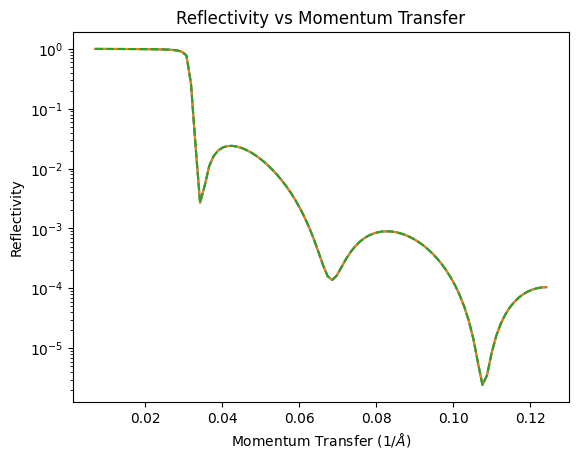

In [ ]:
# For the fitting, we need to define a model.
s_pol_function = fit.ReflectModel(
    structure=slab,  # The slab we just created
    energy=energy.to(ureg.eV).magnitude,  # Energy in eV
    pol="s",  # S-polarized light
    name="Zinc Phthalocyanine Reflectivity Model",  # Name of the model
)
p_pol_function = fit.ReflectModel(
    structure=slab,  # The slab we just created
    pol="p",  # P-polarized light
    energy=energy.to(ureg.eV).magnitude,  # Energy in eV
    name="Zinc Phthalocyanine Reflectivity Model",  # Name of the model
)
# Here we model the s and p polarized reflectivity for the slab we just created.
# to calculate the reflectivity, we need to pass the q values (momentum transfer)
# into the model.

MAX_THETA = 10 * ureg.deg  # Maximum scattering angle for the plot, this is a guess

theta = (
    np.linspace(0.01, MAX_THETA, 100) * ureg.deg
)  # Scattering angles from 0 to 10 degrees
q = momentum_transfer(energy, theta)  # Calculate momentum transfer

s_pol_reflectivity = s_pol_function(
    q.to(ureg.angstrom**-1).magnitude
)  # S-polarized reflectivity
p_pol_reflectivity = p_pol_function(
    q.to(ureg.angstrom**-1).magnitude
)  # P-polarized reflectivity
# calculate from s and p pol the unpolarized reflectivity
u_pol_reflectivity = 0.5 * (s_pol_reflectivity + p_pol_reflectivity)

# Now we can plot the reflectivity for both polarizations.
fig, ax = plt.subplots()
ax.plot(q.to(ureg.angstrom**-1), s_pol_reflectivity, label="S-Polarized Reflectivity")
ax.plot(q.to(ureg.angstrom**-1), p_pol_reflectivity, label="P-Polarized Reflectivity")
ax.plot(
    q.to(ureg.angstrom**-1),
    u_pol_reflectivity,
    label="Unpolarized Reflectivity",
    linestyle="--",
)
ax.set_xlabel(r"Momentum Transfer $(1/\AA)$")
ax.set_ylabel("Reflectivity")
ax.set_title("Reflectivity vs Momentum Transfer")
ax.set_yscale("log")  # Reflectivity is often plotted on a logarithmic scale